 <!DOCTYPE html>
<html>
<head>
  <title>ESI CNN noise prediction </title>
</head>
<body>

<h1>CNN parameter prediction from noisy experimental data</h1>
<p> </p>
<p>We load the experimental data set from "ExperimentalData" file.  We reshape and normalize them. We apply noise to the experimental data set (cell 6). We load the CNN model retrained with the noisy data and use it to predict the parameters from noisy data. We renormalise predicted parameters (cell 12) and put them back into the growth model. Based on the parameters we reproduce the thin film growth scenario (thickness and roughness evolution). In the end, we generate new XRR curves based on the predicted film growth scenario (cell 15).</p>

</body>
</html>

In [1]:
import os

#os.environ["CUDA_VISIBLE_DEVICES"]="/gpu:0"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
import keras


In [2]:
import matplotlib.pylab as plt
import numpy as np
import pickle
import matplotlib

from matplotlib import image
from matplotlib import pyplot

In [3]:
%matplotlib inline




In [4]:
from keras.models import load_model, Sequential
from keras.layers import Dense, Dropout, Activation, Dropout, Flatten, BatchNormalization
from keras import metrics
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


In [5]:
exp_0 = np.load("ExperimentalData/Data_DIP_403K.dat", allow_pickle = True)
exp_1 = np.load("ExperimentalData/Labels_DIP_403K.dat", allow_pickle = True)

print(exp_0.shape,np.min(exp_0))
exp_new = exp_0[1:,:]
print(exp_new.shape)
for i in range(80):
    for j in range(109):
        if exp_new[i,j] >1:
            exp_new[i,j] = 1


origin = tf.reshape(exp_new, [1,80,109,1])

(81, 109) 1.8177991864864553e-06
(80, 109)


/tmp/ipykernel_92111/993230009.py:16: RuntimeWarning: divide by zero encountered in log
  noisyr = (np.log(noisyr) +20)/(20)


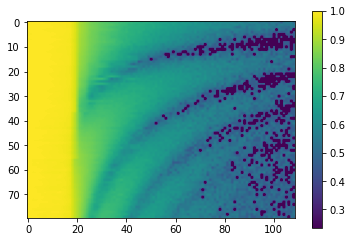

In [6]:
#NOISE
#cps=100000
target=exp_new
target=np.reshape(target, [8720])

from scipy.stats import poisson
from numpy import inf

noisyr_a = []

A = 1
cps = 5e4

for i in range(A):
    noisyr = poisson.rvs(mu=target*cps, size=8720)/cps
    noisyr = (np.log(noisyr) +20)/(20)
    noisyr[noisyr == -inf] = 0
    noisyr_a.append(noisyr)

exp_noise = tf.reshape(noisyr_a, [A,80,109,1])

plt.imshow(exp_noise[A-1,:,:,:])
plt.colorbar()
plt.savefig('Noise'+str(cps)+'.svg', format='svg', dpi=600)
plt.clim(1, 0.26) 
plt.show()

In [7]:
model = load_model('conv_models/20220123_Noise_adagrad10')  #Noisy

In [8]:
print(exp_new)
print(exp_new.shape)

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 9.86600280e-05
  9.49243619e-05 9.33801098e-05]
 [9.85083065e-01 9.80482403e-01 9.75350253e-01 ... 9.37923487e-05
  9.05024970e-05 8.91397193e-05]
 [9.96211299e-01 9.92058570e-01 9.87423621e-01 ... 7.22183172e-05
  6.89906736e-05 6.76632093e-05]
 ...
 [9.93256188e-01 9.94183522e-01 9.95224164e-01 ... 3.14493386e-05
  3.13600599e-05 3.13221996e-05]
 [9.99999993e-01 9.89167865e-01 9.77163667e-01 ... 3.03059528e-05
  2.94385907e-05 2.90775811e-05]
 [9.91398035e-01 9.95035376e-01 9.99128980e-01 ... 2.94854218e-05
  2.79022571e-05 2.72555312e-05]]
(80, 109)


In [9]:
labels_predicted = model.predict(exp_noise)
curve_number = np.linspace(0, 80, 80)

model = tf.keras.models.load_model('my_model_image')

pip install tqdm

In [10]:
from numpy import exp, array, insert
from math import log, sqrt, e


import numpy as np
from scipy import integrate

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.widgets import CheckButtons, Cursor

from tqdm import tqdm

print('Module imports finished')

###############################################################################
###############      Trofimov-model for layer coverages         ###############
###############################################################################

def trofimov(X, t, *args):
    """
    X: list of differential equations to solve
    t: independent variable
    args: Xc, R123
        Xc: list of theta criticals
        R123 = R1,R2,R3,R: growth rates for different layers
    """
    
    def Xi(Theta, ThetaC):
        """ calculate Xi_n for Theta_n and ThetaC_n """
        
        if Theta > ThetaC:
            if Theta >= 1: return 1 #catch rounding errors, math domain error
            if Theta <= 0: return 0
            if ThetaC >= 1: return 1 #catch rounding errors, math domain error
            if ThetaC <= 0: return 0
            expo1 = sqrt(-log(1-Theta))
            expo2 = sqrt(-log(1-ThetaC))
            return 1 - exp(-(expo1-expo2)*(expo1-expo2))
        else: return 0
    
    Xc, R123 = args
    R1, R2, R3, R = R123
    N = len(Xc)

    # Rate equations for different rates for the first four ML
    eqn1 = 0
    if X[0] < 0.99999999:
        eqn1 = R1 * (1-X[0]) + R2 * (X[0] - Xi(X[0],Xc[0]))

    eqn2 = R2 * (Xi(X[0],Xc[0]) - X[1]) + R * (X[1] - Xi(X[1],Xc[1]))

    eqn3 = R3 * (Xi(X[1],Xc[1]) - X[2]) + R * (X[2] - Xi(X[2],Xc[2]))

    eqn = [R*(Xi(X[n-2],Xc[n-2]) - Xi(X[n-1],Xc[n-1])) for n in range(4,N+1)]
    
    return array([eqn1, eqn2, eqn3] + eqn)


###############################################################################
###############     Functions for calculations      ###############
###############################################################################

def calc_all(t, R123, ThetaC):
    """ Calculate coverages, thickness, roughness, reflectivity """
    
    X0 = [0]*N                          # layer-coverages for t=0

    X = integrate.odeint(trofimov, X0, t, args=(ThetaC,R123), mxstep=500)[:]
    coverages = np.transpose(X)     # Coverages in a.u.
    thickness = sum(coverages)      # Total film thickness in a.u.
    # Film roughness in [ML]
    roughness = np.sqrt(abs(sum([(coverages[i] - coverages[i+1])
                              *(i+1 - thickness)**2 for i in range(N-1)])))

    return X, coverages, thickness, roughness



Module imports finished


In [11]:
label_pred = labels_predicted[:,:]

In [12]:
G1=label_pred[:,0]+0.1 #renormalized

G2 = label_pred[:,1] + 0.2

G3 = label_pred[:,2] + 0.2

G4 = label_pred[:,3]/0.55


a=label_pred[:,4]/1.5

b=(label_pred[:,5]*1.3)-0.5

c=label_pred[:,6]/2

d = (label_pred[:,7]*7.5)-7.1

g = label_pred[:,8]/9

sld=label_pred[:,9]*2e15


x = np.linspace(0, 35, 35)
t = np.arange(0, 16, 0.2).tolist()
z1 = np.zeros((35,0))
N=35
roughness_m=np.zeros((80,0))
thickness_m=np.zeros((80,0))
label=[]

for i in range(A):
    f = 0
    z = a[i]*(((0.5*np.tanh(-0.5*(x+d[i]))+0.5))/((0.5*np.tanh(-0.5*d[i])+0.5)))
    for j in range (35):
        if z[j] > c[i]:
            z[j] = z[j]
            f = j
        else:    
            z[j] = (c[i]-g[i])*e**(-b[i]*x[j-f])+g[i]
        
    z = z.reshape(N,1)
    z1 = np.append(z1, z, axis=1)
    

#multiple grow example
for i in range(A):
    gr = [G1[i], G2[i], G3[i], G4[i]]
    thetacrit = z1[:,i]
    out = calc_all(t,gr,thetacrit)
    Roug = out[3].reshape(80,1)
    thick = out[2].reshape(80,1)
    thickness_m = np.append(thickness_m, thick, axis=1)
    roughness_m = np.append(roughness_m, Roug, axis=1)
    lab = G1[i], G2[i], G3[i], G4[i], a[i], b[i], c[i], d[i], sld[i]
    label.append(lab)

In [13]:
# print(thickness_m)
# print(roughness_m)
# print(sld)
# from numpy import savetxt


In [14]:
import numpy as np
from data_handling import make_reflectivity_curves
import matplotlib.pyplot as plt

In [15]:
q_values = np.linspace(0.01, 0.14, 109)
q_values = q_values * 1e10

n_samples = 1
training_data_output = np.zeros([len(q_values), 0])

100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


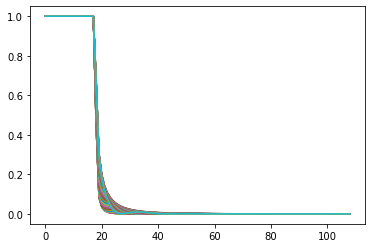

In [16]:
from numpy import append
for i in tqdm(range (1)):
    
    
    for x in range (0,80):
        
        thickness = np.array([thickness_m[x,i]*16.6*1e-10, 10.86*1e-10, 0*1e-10]) 
        repetitions = n_samples
        thicknesses = np.tile(thickness, (repetitions, 1))
        roughness = np.array([roughness_m[x,i]*16.6*1e-10, 5.612*1e-10, 1*1e-11])
        repetitions = n_samples
        roughnesses = np.tile(roughness, (repetitions, 1))

        SLD = np.array([sld[i], 1.903*1e15, 1.977*1e+15]) ###(oxide,bulk)
        repetitions = n_samples
        SLDs = np.tile(SLD, (repetitions, 1))
        training_reflectivity = make_reflectivity_curves(
                q_values, thicknesses, roughnesses, SLDs, n_samples)

        training_data_output = append(training_data_output, training_reflectivity, axis=1)

In [17]:
T_v_n = training_data_output
T_v = np.log(training_data_output)


Training_data_v = (T_v+18.420680743952367)/(4.440892098500625e-16+18.420680743952367)
Training_data_v_n = (T_v_n-np.min(T_v_n))/(np.max(T_v_n)-np.min(T_v_n))

Training_data_v_nn = e**(Training_data_v)

T_va = np.transpose(Training_data_v)
T_va_n = np.transpose(T_v_n)
Training_data_v_nn = np.transpose(Training_data_v_nn)

print(T_va.shape)

T_v = tf.reshape(T_va, [1, 80, 109,1])

print(np.max(T_v_n), np.min(T_v_n))

(80, 109)
1.0000000000000004 1.9744213050869773e-07


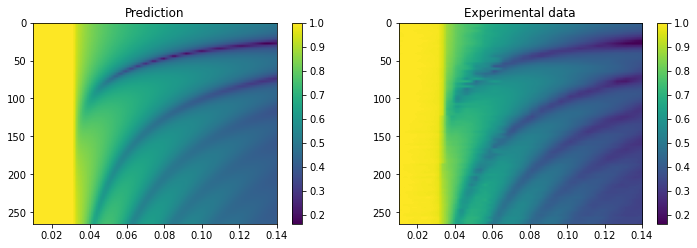

[0.9320894  0.49077207 0.5947011  0.58034945 0.4050942  0.87682843
 0.34435174 0.36245757 0.34967402 0.53787196]


In [18]:
T_xv = tf.reshape(np.log(origin), [1, 80, 109]) 
f, axarr = plt.subplots(1,2, figsize=(12,3.7))

pos0 = axarr[1].imshow(T_xv[-1,:,:], extent=[0.01,0.14,265.6,0], aspect="auto")
pos1 = axarr[0].imshow(T_v[-1,:,:], extent=[0.01,0.14,265.6,0], aspect="auto")

plt.colorbar(pos1, ax=axarr[1])
plt.colorbar(pos1, ax=axarr[0])

axarr[1].set_title('Experimental data')
axarr[0].set_title('Prediction')

plt.show()
print(label_pred[0,:])